In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_log_error

In [20]:
oil_data = pd.read_csv('oil.csv')
stores_data = pd.read_csv('stores.csv')
holidays_data = pd.read_csv('holidays_events.csv')
test_data = pd.read_csv('test.csv')
train_data = pd.read_csv('train.csv')

In [21]:
stores_data.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [22]:
holidays_data.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [23]:
print(f'train {train_data.shape}')
print(f'test {test_data.shape}')
print(f'stores {stores_data.shape}')
print(f'oil {oil_data.shape}')
print(f'holidays {holidays_data.shape}')

train (3000888, 6)
test (28512, 5)
stores (54, 5)
oil (1218, 2)
holidays (350, 6)


In [24]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,3000888.0,1.500444e+06,866281.891642,0.0,750221.75,1500443.5,2.250665e+06,3000887.0
store_nbr,3000888.0,2.750000e+01,15.585787,1.0,14.00,27.5,4.100000e+01,54.0
sales,3000888.0,3.577757e+02,1101.997721,0.0,0.00,11.0,1.958473e+02,124717.0
onpromotion,3000888.0,2.602770e+00,12.218882,0.0,0.00,0.0,0.000000e+00,741.0


In [25]:
train_data= train_data.set_index(train_data['date'])
train_data.index.names = ['date_time']
train_data.index = pd.to_datetime(train_data.index)

In [26]:
def split_date_time(df):
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['weekday'] = df.index.weekday
    df['year'] = df.index.year
    return df

In [27]:
train_data = split_date_time(train_data)
train_data['is_weekend'] = train_data['weekday'].apply(lambda x: 1 if x>4 else 0)
train_data.tail()

,id,date,store_nbr,family,sales,onpromotion,month,day,weekday,year,is_weekend
date_time,,,,,,,,,,,
2017-08-15,3000883,2017-08-15,9,POULTRY,438.133,0,8,15,1,2017,0
2017-08-15,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,8,15,1,2017,0
2017-08-15,3000885,2017-08-15,9,PRODUCE,2419.729,148,8,15,1,2017,0
2017-08-15,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,8,15,1,2017,0
2017-08-15,3000887,2017-08-15,9,SEAFOOD,16.000,0,8,15,1,2017,0


In [29]:
from datetime import datetime

train_data2 = train_data.copy()
train_data2['date'] = pd.to_datetime(train_data2['date'], format='%Y-%m-%d')

pandas.core.series.Series

In [30]:
from datetime import datetime

oil_data2 = oil_data.copy()
oil_data2['date'] = pd.to_datetime(oil_data2['date'], format='%Y-%m-%d')

print(oil_data2['date'])

0      2013-01-01
1      2013-01-02
2      2013-01-03
3      2013-01-04
4      2013-01-07
          ...    
1213   2017-08-25
1214   2017-08-28
1215   2017-08-29
1216   2017-08-30
1217   2017-08-31
Name: date, Length: 1218, dtype: datetime64[ns]


In [31]:
oil_data

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


In [33]:
oil_data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


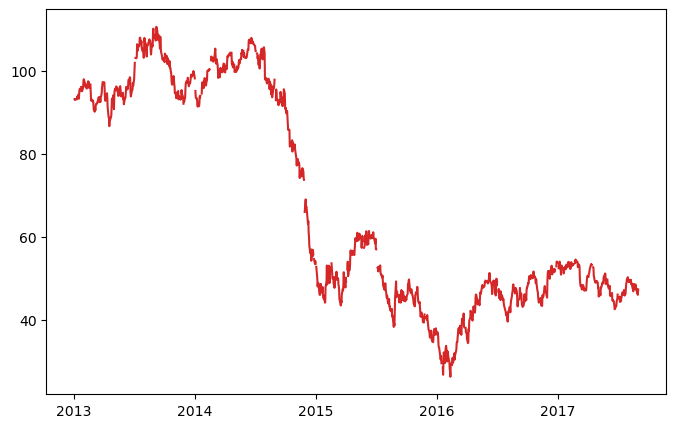

In [34]:
plt.figure(figsize=(8,5)) #, dpi= 80)
plt.plot('date', 'dcoilwtico', data=oil_data2, color='tab:red')
plt.show()

In [35]:
df_final = pd.merge(train_data,oil_data,on="date",how="left").merge(right=stores_data,on="store_nbr",how="left").merge(right=holidays_data,on="date",how="left")
df_final.describe().T

,count,mean,std,min,25%,50%,75%,max
id,3054348.0,1.504277e+06,866261.012008,0.00,754676.75,1507571.50,2255120.250,3000887.00
store_nbr,3054348.0,2.750000e+01,15.585787,1.00,14.00,27.50,41.000,54.00
sales,3054348.0,3.590209e+02,1107.285897,0.00,0.00,11.00,196.011,124717.00
onpromotion,3054348.0,2.617480e+00,12.254939,0.00,0.00,0.00,0.000,741.00
month,3054348.0,6.222870e+00,3.374251,1.00,3.00,6.00,9.000,12.00
day,3054348.0,1.565694e+01,8.801398,1.00,8.00,16.00,23.000,31.00
weekday,3054348.0,3.008168e+00,2.001442,0.00,1.00,3.00,5.000,6.00
year,3054348.0,2.014842e+03,1.345607,2013.00,2014.00,2015.00,2016.000,2017.00
is_weekend,3054348.0,2.876313e-01,0.452658,0.00,0.00,0.00,1.000,1.00
dcoilwtico,2099196.0,6.801587e+01,25.691342,26.19,46.41,53.43,95.810,110.62


In [36]:
df_final.isnull().sum()

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
month                0
day                  0
weekday              0
year                 0
is_weekend           0
dcoilwtico      955152
city                 0
state                0
type_x               0
cluster              0
type_y         2551824
locale         2551824
locale_name    2551824
description    2551824
transferred    2551824
dtype: int64

In [37]:
df_final['dcoilwtico']= df_final['dcoilwtico'].fillna(0)
df_final.query('date=="2016-04-16"')

,id,date,store_nbr,family,sales,onpromotion,month,day,weekday,year,...,dcoilwtico,city,state,type_x,cluster,type_y,locale,locale_name,description,transferred
2161566,2134836,2016-04-16,1,AUTOMOTIVE,6.000,0,4,16,5,2016,...,0.0,Quito,Pichincha,D,13,Event,National,Ecuador,Terremoto Manabi,False
2161567,2134837,2016-04-16,1,BABY CARE,0.000,0,4,16,5,2016,...,0.0,Quito,Pichincha,D,13,Event,National,Ecuador,Terremoto Manabi,False
2161568,2134838,2016-04-16,1,BEAUTY,4.000,0,4,16,5,2016,...,0.0,Quito,Pichincha,D,13,Event,National,Ecuador,Terremoto Manabi,False
2161569,2134839,2016-04-16,1,BEVERAGES,2073.000,5,4,16,5,2016,...,0.0,Quito,Pichincha,D,13,Event,National,Ecuador,Terremoto Manabi,False
2161570,2134840,2016-04-16,1,BOOKS,0.000,0,4,16,5,2016,...,0.0,Quito,Pichincha,D,13,Event,National,Ecuador,Terremoto Manabi,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2163343,2136613,2016-04-16,9,POULTRY,668.427,2,4,16,5,2016,...,0.0,Quito,Pichincha,B,6,Event,National,Ecuador,Terremoto Manabi,False
2163344,2136614,2016-04-16,9,PREPARED FOODS,135.720,0,4,16,5,2016,...,0.0,Quito,Pichincha,B,6,Event,National,Ecuador,Terremoto Manabi,False
2163345,2136615,2016-04-16,9,PRODUCE,1496.493,0,4,16,5,2016,...,0.0,Quito,Pichincha,B,6,Event,National,Ecuador,Terremoto Manabi,False
2163346,2136616,2016-04-16,9,SCHOOL AND OFFICE SUPPLIES,2.000,0,4,16,5,2016,...,0.0,Quito,Pichincha,B,6,Event,National,Ecuador,Terremoto Manabi,False


In [38]:
df_final = df_final.fillna("No holiday")
df_final.loc[df_final.transferred == True,"type_y"] = "No holiday"

In [39]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054348 entries, 0 to 3054347
Data columns (total 21 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
 6   month        int64  
 7   day          int64  
 8   weekday      int64  
 9   year         int64  
 10  is_weekend   int64  
 11  dcoilwtico   float64
 12  city         object 
 13  state        object 
 14  type_x       object 
 15  cluster      int64  
 16  type_y       object 
 17  locale       object 
 18  locale_name  object 
 19  description  object 
 20  transferred  object 
dtypes: float64(2), int64(9), object(10)
memory usage: 512.7+ MB


In [40]:
df_final.describe().T

,count,mean,std,min,25%,50%,75%,max
id,3054348.0,1.504277e+06,866261.012008,0.0,754676.75,1507571.50,2255120.250,3000887.00
store_nbr,3054348.0,2.750000e+01,15.585787,1.0,14.00,27.50,41.000,54.00
sales,3054348.0,3.590209e+02,1107.285897,0.0,0.00,11.00,196.011,124717.00
onpromotion,3054348.0,2.617480e+00,12.254939,0.0,0.00,0.00,0.000,741.00
month,3054348.0,6.222870e+00,3.374251,1.0,3.00,6.00,9.000,12.00
day,3054348.0,1.565694e+01,8.801398,1.0,8.00,16.00,23.000,31.00
weekday,3054348.0,3.008168e+00,2.001442,0.0,1.00,3.00,5.000,6.00
year,3054348.0,2.014842e+03,1.345607,2013.0,2014.00,2015.00,2016.000,2017.00
is_weekend,3054348.0,2.876313e-01,0.452658,0.0,0.00,0.00,1.000,1.00
dcoilwtico,3054348.0,4.674603e+01,38.051512,0.0,0.00,47.02,91.530,110.62


In [41]:
df_final.query('type_y=="No holiday"')

,id,date,store_nbr,family,sales,onpromotion,month,day,weekday,year,...,dcoilwtico,city,state,type_x,cluster,type_y,locale,locale_name,description,transferred
1782,1782,2013-01-02,1,AUTOMOTIVE,2.000,0,1,2,2,2013,...,93.14,Quito,Pichincha,D,13,No holiday,No holiday,No holiday,No holiday,No holiday
1783,1783,2013-01-02,1,BABY CARE,0.000,0,1,2,2,2013,...,93.14,Quito,Pichincha,D,13,No holiday,No holiday,No holiday,No holiday,No holiday
1784,1784,2013-01-02,1,BEAUTY,2.000,0,1,2,2,2013,...,93.14,Quito,Pichincha,D,13,No holiday,No holiday,No holiday,No holiday,No holiday
1785,1785,2013-01-02,1,BEVERAGES,1091.000,0,1,2,2,2013,...,93.14,Quito,Pichincha,D,13,No holiday,No holiday,No holiday,No holiday,No holiday
1786,1786,2013-01-02,1,BOOKS,0.000,0,1,2,2,2013,...,93.14,Quito,Pichincha,D,13,No holiday,No holiday,No holiday,No holiday,No holiday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3052561,2999101,2017-08-14,9,POULTRY,283.429,0,8,14,0,2017,...,47.59,Quito,Pichincha,B,6,No holiday,No holiday,No holiday,No holiday,No holiday
3052562,2999102,2017-08-14,9,PREPARED FOODS,114.120,0,8,14,0,2017,...,47.59,Quito,Pichincha,B,6,No holiday,No holiday,No holiday,No holiday,No holiday
3052563,2999103,2017-08-14,9,PRODUCE,1348.425,7,8,14,0,2017,...,47.59,Quito,Pichincha,B,6,No holiday,No holiday,No holiday,No holiday,No holiday
3052564,2999104,2017-08-14,9,SCHOOL AND OFFICE SUPPLIES,182.000,11,8,14,0,2017,...,47.59,Quito,Pichincha,B,6,No holiday,No holiday,No holiday,No holiday,No holiday


In [42]:
df_final.tail()

,id,date,store_nbr,family,sales,onpromotion,month,day,weekday,year,...,dcoilwtico,city,state,type_x,cluster,type_y,locale,locale_name,description,transferred
3054343,3000883,2017-08-15,9,POULTRY,438.133,0,8,15,1,2017,...,47.57,Quito,Pichincha,B,6,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,8,15,1,2017,...,47.57,Quito,Pichincha,B,6,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054345,3000885,2017-08-15,9,PRODUCE,2419.729,148,8,15,1,2017,...,47.57,Quito,Pichincha,B,6,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,8,15,1,2017,...,47.57,Quito,Pichincha,B,6,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054347,3000887,2017-08-15,9,SEAFOOD,16.000,0,8,15,1,2017,...,47.57,Quito,Pichincha,B,6,Holiday,Local,Riobamba,Fundacion de Riobamba,False


In [43]:
encode = OrdinalEncoder()

In [44]:
encode.fit(df_final[["city","state"]])

OrdinalEncoder()

In [45]:
df_final[["city","state"]] = encode.transform(df_final[["city","state"]])

In [46]:
df_final['transferred'] =  df_final['transferred'].apply(lambda x: 1 if x == True else 0)

In [47]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054348 entries, 0 to 3054347
Data columns (total 21 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
 6   month        int64  
 7   day          int64  
 8   weekday      int64  
 9   year         int64  
 10  is_weekend   int64  
 11  dcoilwtico   float64
 12  city         float64
 13  state        float64
 14  type_x       object 
 15  cluster      int64  
 16  type_y       object 
 17  locale       object 
 18  locale_name  object 
 19  description  object 
 20  transferred  int64  
dtypes: float64(4), int64(10), object(7)
memory usage: 512.7+ MB


In [48]:
df_final.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'month',
       'day', 'weekday', 'year', 'is_weekend', 'dcoilwtico', 'city', 'state',
       'type_x', 'cluster', 'type_y', 'locale', 'locale_name', 'description',
       'transferred'],
      dtype='object')

In [49]:
df_corr = df_final[['store_nbr','sales','onpromotion','dcoilwtico','city','state','cluster','transferred','month','day','weekday','year','is_weekend']].corr('pearson')

[Text(0.5, 0, 'store_nbr'),
 Text(1.5, 0, 'sales'),
 Text(2.5, 0, 'onpromotion'),
 Text(3.5, 0, 'dcoilwtico'),
 Text(4.5, 0, 'city'),
 Text(5.5, 0, 'state'),
 Text(6.5, 0, 'cluster'),
 Text(7.5, 0, 'transferred'),
 Text(8.5, 0, 'month'),
 Text(9.5, 0, 'day'),
 Text(10.5, 0, 'weekday'),
 Text(11.5, 0, 'year'),
 Text(12.5, 0, 'is_weekend')]

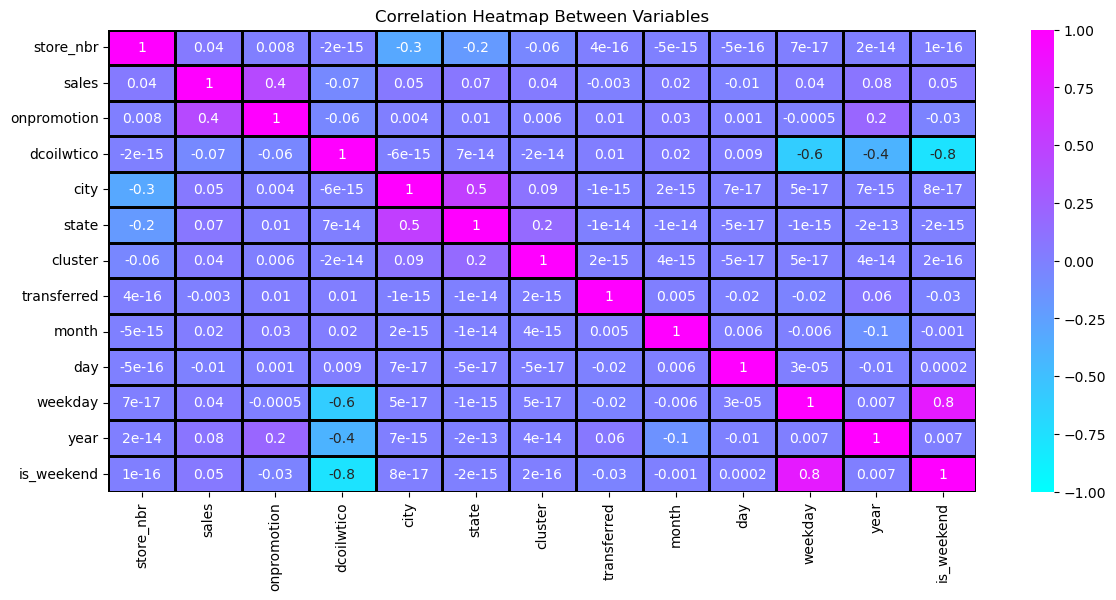

In [50]:
plt.figure(figsize=(14, 6))
heatmap = sns.heatmap(df_corr, annot=True, fmt=".1g", vmin=-1, vmax=1, center=0, cmap="cool", linewidths=1, linecolor="black")
heatmap.set_title("Correlation Heatmap Between Variables")
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90)

In [51]:
X = df_final[['onpromotion','store_nbr','weekday','year','month','day','dcoilwtico',"is_weekend"]].values
y = df_final[['sales']].values

model = LinearRegression()
model2 = GradientBoostingRegressor()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
model3 = XGBRegressor(random_state=1, n_estimators=1500)
model3.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1500, n_jobs=None,
             num_parallel_tree=None, random_state=1, ...)

In [52]:
y_test

array([[133.533],
       [494.815],
       [  2.   ],
       ...,
       [  0.   ],
       [  6.   ],
       [  0.   ]])

In [53]:
test_data

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [54]:
test_merged = pd.merge(left=test_data,right=oil_data,on="date",how="left").merge(right=stores_data,on="store_nbr",how="left").merge(right=holidays_data,on="date",how="left")

In [55]:
test_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28512 entries, 0 to 28511
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           28512 non-null  int64  
 1   date         28512 non-null  object 
 2   store_nbr    28512 non-null  int64  
 3   family       28512 non-null  object 
 4   onpromotion  28512 non-null  int64  
 5   dcoilwtico   21384 non-null  float64
 6   city         28512 non-null  object 
 7   state        28512 non-null  object 
 8   type_x       28512 non-null  object 
 9   cluster      28512 non-null  int64  
 10  type_y       1782 non-null   object 
 11  locale       1782 non-null   object 
 12  locale_name  1782 non-null   object 
 13  description  1782 non-null   object 
 14  transferred  1782 non-null   object 
dtypes: float64(1), int64(4), object(10)
memory usage: 3.5+ MB


In [56]:
test_merged['transferred'] =  test_merged['transferred'].apply(lambda x: 1 if x == True else 0)

In [57]:
test_merged.isnull().sum() 

id                 0
date               0
store_nbr          0
family             0
onpromotion        0
dcoilwtico      7128
city               0
state              0
type_x             0
cluster            0
type_y         26730
locale         26730
locale_name    26730
description    26730
transferred        0
dtype: int64

In [58]:
test_merged[["city","state"]] = encode.transform(test_merged[["city","state"]])
test_merged = test_merged.set_index(test_merged['date'])
test_merged.index.names = ['date_time']
test_merged.index = pd.to_datetime(test_merged.index)
test_merged = split_date_time(test_merged)
test_merged['is_weekend'] = test_merged['weekday'].apply(lambda x: 1 if x>4 else 0)
test_merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28512 entries, 2017-08-16 to 2017-08-31
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           28512 non-null  int64  
 1   date         28512 non-null  object 
 2   store_nbr    28512 non-null  int64  
 3   family       28512 non-null  object 
 4   onpromotion  28512 non-null  int64  
 5   dcoilwtico   21384 non-null  float64
 6   city         28512 non-null  float64
 7   state        28512 non-null  float64
 8   type_x       28512 non-null  object 
 9   cluster      28512 non-null  int64  
 10  type_y       1782 non-null   object 
 11  locale       1782 non-null   object 
 12  locale_name  1782 non-null   object 
 13  description  1782 non-null   object 
 14  transferred  28512 non-null  int64  
 15  month        28512 non-null  int64  
 16  day          28512 non-null  int64  
 17  weekday      28512 non-null  int64  
 18  year         28512 non-null  

In [59]:
y_test.shape

(610870, 1)

In [60]:
y_pred = model3.predict(test_merged[['onpromotion','store_nbr','weekday','year','month','day','dcoilwtico',"is_weekend"]].values)
# print(mean_squared_log_error(y_test,y_pred))

In [61]:
test_merged['sales'] = y_pred

In [62]:
test_merged.head()

,id,date,store_nbr,family,onpromotion,dcoilwtico,city,state,type_x,cluster,...,locale,locale_name,description,transferred,month,day,weekday,year,is_weekend,sales
date_time,,,,,,,,,,,,,,,,,,,,,
2017-08-16,3000888,2017-08-16,1,AUTOMOTIVE,0,46.8,18.0,12.0,D,13,...,NaN,NaN,NaN,0,8,16,2,2017,0,41.454830
2017-08-16,3000889,2017-08-16,1,BABY CARE,0,46.8,18.0,12.0,D,13,...,NaN,NaN,NaN,0,8,16,2,2017,0,41.454830
2017-08-16,3000890,2017-08-16,1,BEAUTY,2,46.8,18.0,12.0,D,13,...,NaN,NaN,NaN,0,8,16,2,2017,0,64.658066
2017-08-16,3000891,2017-08-16,1,BEVERAGES,20,46.8,18.0,12.0,D,13,...,NaN,NaN,NaN,0,8,16,2,2017,0,1189.543335
2017-08-16,3000892,2017-08-16,1,BOOKS,0,46.8,18.0,12.0,D,13,...,NaN,NaN,NaN,0,8,16,2,2017,0,41.454830


In [63]:
outp = test_merged[["id","sales"]]

In [64]:
outp

,id,sales
date_time,,
2017-08-16,3000888,41.454830
2017-08-16,3000889,41.454830
2017-08-16,3000890,64.658066
2017-08-16,3000891,1189.543335
2017-08-16,3000892,41.454830
...,...,...
2017-08-31,3029395,284.320129
2017-08-31,3029396,35.751881
2017-08-31,3029397,284.320129
